In [6]:
from PIL import Image, ImageOps
import torch
from torch import Tensor, linalg
import numpy as np
from IPython.display import Latex
import matplotlib.pyplot as plt
import os

# Generate the Data Matrix and the Label vector
Read data into torch.Tensor

In [7]:
torch.set_default_dtype(torch.float64)

image_count_per_person = 10
person_count = 40
images = [Image.open(f"../data/s{j + 1}/{i + 1}.pgm") for j in range(person_count) for i in range(image_count_per_person)]

all_data = np.array(images)
all_data.resize((image_count_per_person * person_count, images[0].width * images[0].height))
all_data = Tensor(all_data)

labels = torch.tensor([i for i in range(person_count) for _ in range(image_count_per_person)])

# Split the Dataset into Training and Test sets
Split dataset into training and test data taking the even indexed rows for testing and the odd indexed rows for training

In [8]:
odd_indices = [i for i in range(len(all_data)) if i % 2 == 1]
even_indices = [i for i in range(len(all_data)) if i % 2 == 0]

training_data = all_data[odd_indices]
test_data = all_data[even_indices]

training_labels = labels[odd_indices]
test_labels = labels[even_indices]

# Classification using PCA
## Original PCA Algorithm
Running Time: $O(d^3)$ to calculate the eigen values and eigen vectors of $\Sigma_{d \times d}$ matrix\
\
![pca](../res/pca.PNG)

In [4]:
def pca1(data: Tensor, alpha: float) -> Tensor:
    centered_data: Tensor = data - data.mean(0)
    covariance: Tensor = 1 / len(data) * centered_data.T @ centered_data

    eigen_values, eigen_vectors = linalg.eigh(covariance)

    variance: float = covariance.trace().numpy()
    projected_variance = 0.0

    i = len(eigen_values) - 1
    while i >= 0 and projected_variance < alpha * variance:
        projected_variance += eigen_values[i]
        i -= 1

    eigen_vectors = torch.fliplr(eigen_vectors[:, i + 1:])

    return data @ eigen_vectors

In [5]:
# pca1(training_data, 0.8)

## Enhanced PCA algorithm
Running Time: $O(n^3)$ to calculate the eigen values and eigen vectors of $\frac{1}n\mathbf{X}_{n \times d}\mathbf{X}_{d\times n}^T$ matrix\
Reference: Section 12.1.4 from C. M. Bishop, Pattern Recognition and Machine Learning

In [6]:
def pca2(data: Tensor, alpha: float) -> Tensor:
    centered_data = data - data.mean(0)

    eigen_values, eigen_vectors = torch.linalg.eig(1 / len(data) * centered_data @ centered_data.T)
    eigen_values = eigen_values.real
    eigen_vectors = eigen_vectors.real

    variance: float = (1 / len(data) * centered_data.T @ centered_data).trace().numpy()
    projected_variance = 0.0

    idxs = torch.argsort(eigen_values, descending=True)
    eigen_values = eigen_values[idxs]
    eigen_vectors = eigen_vectors[:, idxs]

    i = 0
    while i < len(eigen_values) and projected_variance < alpha * variance:
        projected_variance += eigen_values[i]
        i += 1

    new_basis = centered_data.T @ eigen_vectors
    new_basis /= torch.sqrt(eigen_values * len(data))

    new_basis = new_basis[:, :i]

    return new_basis

In [7]:
alpha = 0.95

new_basis = pca2(training_data, alpha)

# project training data
projected_training_data = training_data @ new_basis

Classify test data using KNN

In [12]:
def knn(test_data: Tensor, training_data: Tensor, k: int):
    distance_matrix = torch.cdist(test_data, training_data)
    indices = torch.argsort(distance_matrix, dim=1)
    return indices[:, :k]

In [25]:
result_labels = training_labels[knn(test_data @ new_basis, projected_training_data, 1)].mode(keepdim=True)[0]

tensor(6272.0381)


In [10]:
Latex(rf"for $\alpha$ = {alpha}, accuracy = {1 - torch.count_nonzero(result_labels - test_labels[:, None]) / len(result_labels)}")

<IPython.core.display.Latex object>

In [44]:
def pca_classify(training_data: Tensor, test_data: Tensor, training_labels: Tensor, test_labels: Tensor, alpha: float, k: int) -> float:
    new_basis = pca2(training_data, alpha)
    projected_training_data = training_data @ new_basis
    result_labels = training_labels[knn(test_data @ new_basis, projected_training_data, k)].mode(keepdim=True)[0]
    return 1 - torch.count_nonzero(result_labels - test_labels[:, None]) / len(result_labels)

In [12]:
alpha = 0.8
accuracy = pca_classify(training_data, test_data, training_labels, test_labels, alpha, 1)
Latex(rf"for $\alpha$ = {alpha}, accuracy = {accuracy}")

<IPython.core.display.Latex object>

In [13]:
alpha = 0.85
accuracy = pca_classify(training_data, test_data, training_labels, test_labels, alpha, 1)
Latex(rf"for $\alpha$ = {alpha}, accuracy = {accuracy}")

<IPython.core.display.Latex object>

In [14]:
alpha = 0.9
accuracy = pca_classify(training_data, test_data, training_labels, test_labels, alpha, 1)
Latex(rf"for $\alpha$ = {alpha}, accuracy = {accuracy}")

<IPython.core.display.Latex object>

In [15]:
alpha = 0.95
accuracy = pca_classify(training_data, test_data, training_labels, test_labels, alpha, 1)
Latex(rf"for $\alpha$ = {alpha}, accuracy = {accuracy}")

<IPython.core.display.Latex object>

It is clear that the accuracy increases by increasing $\alpha$ ($\alpha \propto$ accuracy).\
However, the accuracy seems to decreases as $\alpha$ goes from 0.9 to 0.95

# Classification using LDA
## Original LDA Algorithm
Running Time: $O(d^3)$ to calculate the eigen values and eigen vectors of $\Sigma_{d \times d}$ matrix\
\
![lda](../res/lda.PNG)

In [13]:
def LDA(D , y):
    n_features = len(D[0])
    classes = torch.unique(y)
    n_classes = len(classes)

    overall_mean = torch.mean(D ,dim=0)

    # between-class scatter
    Sb = torch.zeros((n_features , n_features))

    # within-class scatter
    S = torch.zeros((n_features , n_features))

    for i in classes:
        Kth_class = D[y == i]
        cur_mean = torch.mean(Kth_class , dim=0)
       
        # calculate between class scatter matrix
        centered_kth_mean = (cur_mean - overall_mean).unsqueeze(1)
        Sb += (Kth_class.shape[0] * Tensor.matmul(centered_kth_mean,centered_kth_mean.T))

        # calculate within class scatter matrix
        centered_kth_class = Kth_class - cur_mean
        S += Tensor.matmul(centered_kth_class.T,centered_kth_class)


    #compute matrix (S^-1*B) 
    A = linalg.pinv(S) @ Sb
    
    #Compute the eignValues and eignVectors
    eigenvalues, eigenvectors = linalg.eig(A)
    eigenvalues, eigenvectors =eigenvalues.real, eigenvectors.real
    
    #Sort the eignValues and eignVectors
    idxs = torch.argsort(eigenvalues,descending=True)
    eigenvectors = eigenvectors[:,idxs]

    return eigenvectors[:,:n_classes-1]

In [14]:
def lda_classify(training_data, test_data, training_labels, test_labels, k):
    projection_matrix = LDA(training_data,training_labels) 
    projected_training_matrix = training_data @ projection_matrix
    projected_test_matrix = test_data @ projection_matrix
    
    result_labels = training_labels[knn(projected_test_matrix,projected_training_matrix, k)].mode(keepdim=True)[0]
    return 1 - torch.count_nonzero(result_labels - test_labels[:, None]) / len(result_labels)

In [15]:
k = 1

accuracy = lda_classify(training_data, test_data, training_labels, test_labels, k)
print(f"accuracy = {accuracy}")

# Classifier Tuning
## PCA using $\alpha$ = 0.9

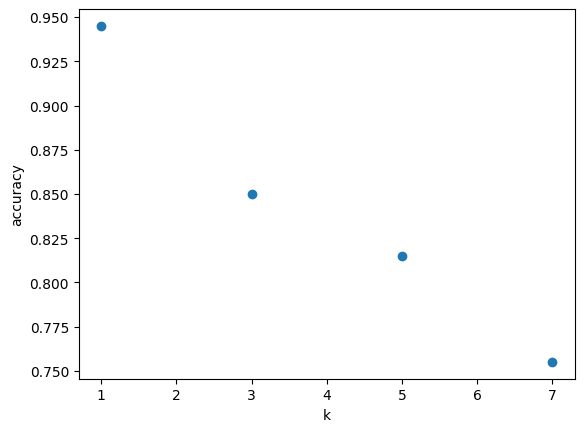

In [16]:
ks = [1, 3, 5, 7]
alpha = 0.9

accuracies = [pca_classify(training_data, test_data, training_labels, test_labels, alpha, k) for k in ks]
plt.xlabel("k")
plt.ylabel("accuracy")
plt.scatter(ks, accuracies)

Using KNN classification with k = 1 gives the most accurate results

## LDA

In [ ]:
ks = [1, 3, 5, 7]

accuracies = [lda_classify(training_data, test_data, training_labels, test_labels, k) for k in ks]
plt.xlabel("k")
plt.ylabel("accuracy")
plt.scatter(ks, accuracies)

![pca](../res/output.PNG)

Using KNN classification with k = 1 gives the most accurate results

# Compare vs Non-Face Images
Read non-face data (iris dataset)

In [36]:
iris_path_1 = "../data/iris/iris-setosa"
iris_path_2 = "../data/iris/iris-versicolour"
iris_path_3 = "../data/iris/iris-virginica"

iris_images = [Image.open(f"{iris_path_1}/{filename}") for filename in os.listdir(iris_path_1)]
iris_images.extend([Image.open(f"{iris_path_2}/{filename}") for filename in os.listdir(iris_path_2)])
iris_images.extend([Image.open(f"{iris_path_3}/{filename}") for filename in os.listdir(iris_path_3)])
iris_images = [ImageOps.grayscale(iris_images[i].resize((92, 112))) for i in range(len(iris_images))]

iris_data = np.array(iris_images)
iris_data.resize((iris_data.shape[0], iris_data.shape[1] * iris_data.shape[2]))
iris_data = Tensor(iris_data)

Split dataset and combine with face dataset

In [182]:
iris_training_indices = [i for i in range(len(iris_data)) if i % 2 == 0]
iris_test_indices = [i for i in range(len(iris_data)) if i % 2 == 1]

iris_training_data = iris_data[iris_training_indices]
iris_test_data = iris_data[iris_test_indices]

iris_training_labels = Tensor([-1 for _ in range(len(iris_training_indices))])
iris_test_labels = Tensor([-1 for _ in range(len(iris_test_indices))])

face_non_face_training_data = torch.vstack((training_data, iris_training_data))
face_non_face_training_labels = torch.hstack((training_labels, iris_training_labels))

## Classify using PCA

In [185]:
alpha = 0.95
k = 1

non_face_accuracy = pca_classify(face_non_face_training_data, iris_test_data, face_non_face_training_labels, iris_test_labels, alpha, k)
face_accuracy = pca_classify(face_non_face_training_data, test_data, face_non_face_training_labels, test_labels, alpha, k)
print(f"accuracy at detecting non-faces = {non_face_accuracy}")
print(f"accuracy at detecting faces = {face_accuracy}")

accuracy at detecting non-faces = 0.9380952380952381
accuracy at detecting faces = 0.935


## Using different number of non-faces

In [48]:
alpha = 0.95
k = 1

number_of_non_faces = [50, 100, 150, 200, 250, 300, 350, 400]

non_face_accuracies = []
face_accuracies = []

for no in number_of_non_faces:
    iris_training_indices = [i for i in range(len(iris_data)) if i % 2 == 0]
    iris_test_indices = [i for i in range(len(iris_data)) if i % 2 == 1]

    iris_training_data = iris_data[:no]
    iris_test_data = iris_data[no:]

    iris_training_labels = Tensor([-1 for _ in range(len(iris_training_data))])
    iris_test_labels = Tensor([-1 for _ in range(len(iris_test_data))])

    face_non_face_training_data = torch.vstack((training_data, iris_training_data))
    face_non_face_training_labels = torch.hstack((training_labels, iris_training_labels))

    non_face_accuracies.append(pca_classify(face_non_face_training_data, iris_test_data, face_non_face_training_labels, iris_test_labels, alpha, k))
    face_accuracies.append(pca_classify(face_non_face_training_data, test_data, face_non_face_training_labels, test_labels, alpha, k))

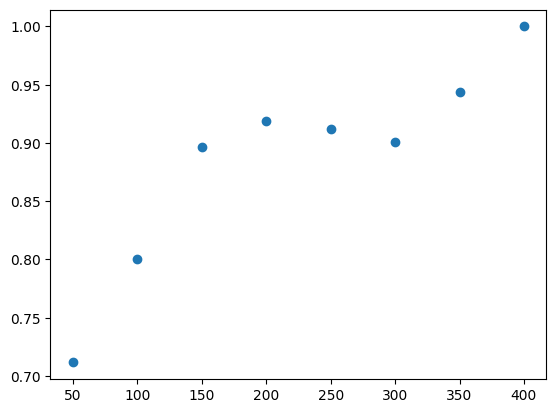

In [49]:
plt.scatter(number_of_non_faces, non_face_accuracies)

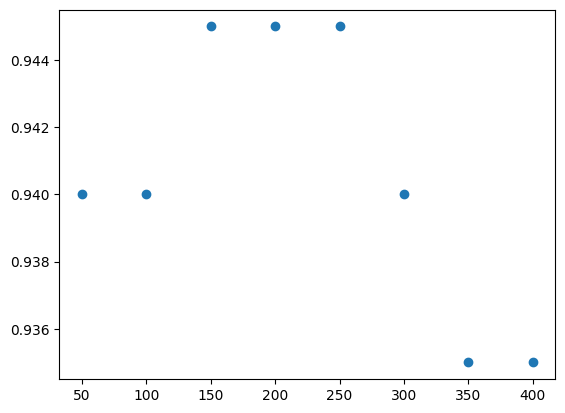

In [50]:
plt.scatter(number_of_non_faces, face_accuracies)

## Classify using LDA
\
Using 40 eigen vectors

In [51]:
k = 1

non_face_accuracy = lda_classify(face_non_face_training_data, iris_test_data, face_non_face_training_labels, iris_test_labels, k)
face_accuracy = lda_classify(face_non_face_training_data, test_data, face_non_face_training_labels, test_labels, k)
print(f"accuracy at detecting non-faces = {non_face_accuracy}")
print(f"accuracy at detecting faces = {face_accuracy}")

RuntimeError: torch.linalg.eig: input tensor should not contain infs or NaNs.

# Bonus
## PCA with 7 training images and 3 test images
\
Splitting dataset into training and test data

In [59]:
training_indices = [i for i in range(len(all_data)) if i % 10 == 0 or i % 10 == 1 or i % 10 == 3 or i % 10 == 4 or i % 10 == 6 or i % 10 == 7 or i % 10 == 9]
test_indices = [i for i in range(len(all_data)) if i % 10 == 2 or i % 10 == 5 or i % 10 == 8]

training_data = all_data[training_indices]
test_data = all_data[test_indices]

training_labels = labels[training_indices]
test_labels = labels[test_indices]

In [18]:
alpha = 0.8
accuracy = pca_classify(training_data, test_data, test_labels, alpha, 1)
Latex(rf"for $\alpha$ = {alpha}, accuracy = {accuracy}")

<IPython.core.display.Latex object>

In [19]:
alpha = 0.85
accuracy = pca_classify(training_data, test_data, test_labels, alpha, 1)
Latex(rf"for $\alpha$ = {alpha}, accuracy = {accuracy}")

<IPython.core.display.Latex object>

In [20]:
alpha = 0.9
accuracy = pca_classify(training_data, test_data, test_labels, alpha, 1)
Latex(rf"for $\alpha$ = {alpha}, accuracy = {accuracy}")

<IPython.core.display.Latex object>

In [21]:
alpha = 0.95
accuracy = pca_classify(training_data, test_data, test_labels, alpha, 1)
Latex(rf"for $\alpha$ = {alpha}, accuracy = {accuracy}")

<IPython.core.display.Latex object>

## LDA with 7 training images and 3 test images

In [ ]:
accuracy = lda_classify(training_data, test_data, test_labels, 1)
Latex(rf"for $\alpha$ = {alpha}, accuracy = {accuracy}")